<a href="https://colab.research.google.com/github/kabirchhabra/Skillslash/blob/main/Time_Series/Tractor_Sales(TimeSeries).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Arima Time Series Analysis

In this case study example, we will learn about time series analysis for a manufacturing operation. Time series analysis and modelling have many business and social applications. It is extensively used to foreacst compnay sales, product demand, stock market trends, agricultural production etc.

The fundamental idea for time series analysis is to decompose the original time series (sales, stock market trends, etc) into severak independent components. Typically, business time series are divided into following four components:

Trend: Overall direction of the series i.e. upwards, downwards etc.

Seasonality: monthly or quaterly patterns.

Cycle: long-term business cycles, they usually come after 5 or 7 years.

Irregular remainder- random noise left after extraction of all the components.

Interference of these components produce the final series. Why bother decomposing the original/actual time series into components? It is much easier to forecast the individual regular patterns produced through decomposition of time series than the actual series.



**Step 0: Problem Definition**

PowerHorse, a tractor and farm equipment manufacturing company, was established a few years after World War II. The company has shown a consistent growth in its revenue from tractor sales since its inception. However, over the years the company has struggled to keep it's inventory and production cost down because of variablitiy in sales and tractor demand. The management is under enomous pressure from the shareholders and board to reduce the production cost. Additionally, thery are also interested in understanding the impact of their marketing and farmer connect efforts towards overall sales. In the same effort, they have fired us a data science and predicitive analytics consultant.


We will develop an ARIMA model to forecast sale/demand of tractor for next 3 years. Additionally, we will also investigate the impact of marketing prograzm on sales by using an exogenous variable ARIMA model. As a part of this project, one of the production units we are analyzing is based in South East Asia. This unit is completely independent and caters to neighbouring geographies. This unit is just a decade and a half old. In 2014, they captured 11% of the market-share, a 14% increase from the previous year. Howeverm being a new unit they have very little bargaining power with their suppliers to implement Just-In_time (JIT) manufactring principles that have worked really well in PowerHorse's base location. Hence, they want to be on top of their production planning to mantain healthy business margins. Monthly, sales forecast is the first step we have suggested to this unit towards effective inventory management.

In [1]:
import warnings
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf
from io import StringIO
import requests
import matplotlib.pyplot as plt

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/himankjn/Sales_Forecast/master/Python/Tractor-Sales.csv')
df.head()

,Month-Year,Number of Tractor Sold
0,Jan-03,141
1,Feb-03,157
2,Mar-03,185
3,Apr-03,199
4,May-03,203


In [3]:
df.tail()

,Month-Year,Number of Tractor Sold
139,Aug-14,848
140,Sep-14,640
141,Oct-14,581
142,Nov-14,519
143,Dec-14,605


We have the data from Jan,2003 to Dec,2014

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Month-Year              144 non-null    object
 1   Number of Tractor Sold  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


In [5]:
dates = pd.date_range(start='2003-01-01', freq='MS', periods=len(df))
dates

DatetimeIndex(['2003-01-01', '2003-02-01', '2003-03-01', '2003-04-01',
               '2003-05-01', '2003-06-01', '2003-07-01', '2003-08-01',
               '2003-09-01', '2003-10-01',
               ...
               '2014-03-01', '2014-04-01', '2014-05-01', '2014-06-01',
               '2014-07-01', '2014-08-01', '2014-09-01', '2014-10-01',
               '2014-11-01', '2014-12-01'],
              dtype='datetime64[ns]', length=144, freq='MS')

In [6]:
import calendar
df['Months'] = dates.month
df['Months'] = df['Months'].apply(lambda x:calendar.month_abbr[x]) #we will get(Jan,Feb) separate months
df['Year'] = dates.year

In [7]:
df.head()

,Month-Year,Number of Tractor Sold,Months,Year
0,Jan-03,141,Jan,2003
1,Feb-03,157,Feb,2003
2,Mar-03,185,Mar,2003
3,Apr-03,199,Apr,2003
4,May-03,203,May,2003


In [8]:
df.drop(['Month-Year'], axis=1, inplace=True)

In [9]:
df.head()

,Number of Tractor Sold,Months,Year
0,141,Jan,2003
1,157,Feb,2003
2,185,Mar,2003
3,199,Apr,2003
4,203,May,2003


In [10]:
#Renaming
df.rename(columns={'Number of Tractor Sold':'Tractor-Sales'},inplace=True)

In [11]:
df.head()

,Tractor-Sales,Months,Year
0,141,Jan,2003
1,157,Feb,2003
2,185,Mar,2003
3,199,Apr,2003
4,203,May,2003


In [12]:
df.set_index(dates, inplace=True)
df.head()

,Tractor-Sales,Months,Year
2003-01-01,141,Jan,2003
2003-02-01,157,Feb,2003
2003-03-01,185,Mar,2003
2003-04-01,199,Apr,2003
2003-05-01,203,May,2003


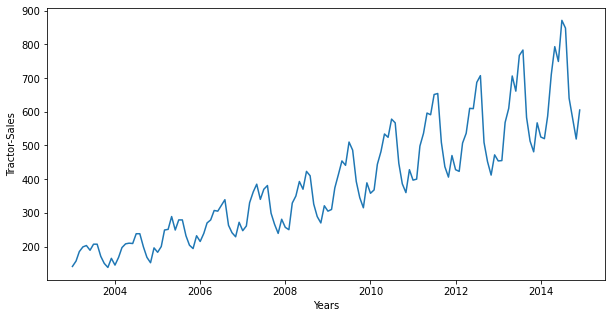

In [13]:
#plot the sales
df_ts = df['Tractor-Sales']
plt.figure(figsize=(10,5))
plt.plot(df_ts)
plt.xlabel('Years')
plt.ylabel('Tractor-Sales')
plt.show()

Now we start with time series decompositon of this data to understand underlying patterns such as trend, seasonality, cycle and irregular remainder for tractor sales. In the above data, a cyclic pattern seems to be non-existent since the unit we are analysing is relatively new unit to notice business cycles. Also in theory, business cyclecs in traditional businesses are observed over a period of 7 or more years. Hence, we won't include business cycles in this time series decompositon exercise. Also, we observe a overall increasing trend across years. We will build our model absed on the following functions:

**Step 1.1: Trend- Time Series Decompositon**

# Determining and Plotting Rolling Statistics

In [14]:
roll_mean = df_ts.rolling(window=12).mean()
roll_std = df_ts.rolling(window=12).std()

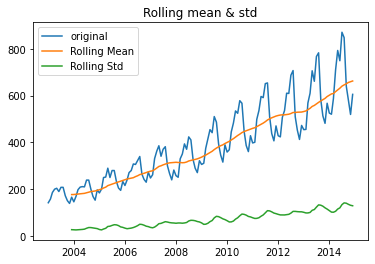

In [15]:
#plotting rolling statistics
orig = plt.plot(df_ts, label='original')
mean = plt.plot(roll_mean, label='Rolling Mean')
std = plt.plot(roll_std, label='Rolling Std')

plt.legend(loc='best')
plt.title('Rolling mean & std')
plt.show()

We can also perform Augmented-dickey-fuller test to check whether the series is stationary or not.

In this case, series is not stationary, as mean and std are not constant.

**Augmented-dickey-fuller-test**

In [16]:
from statsmodels.tsa.stattools import adfuller

In [17]:
X = df['Tractor-Sales'].values
result = adfuller(X)
print('ADF statistic: %f' %result[0])
print(f'p-value: {result[1]}')
print('Critical Values: ')
for key,value in result[4].items():
  print('\t%s: %.3f'%(key,value))

if result[0] < result[4]['5%']:
  print('Reject Ho - Time series is stationary')
else:
  print('Failed to reject Ho - Time series not non-stationary')

ADF statistic: 1.108825
p-value: 0.9952912415248419
Critical Values: 
	1%: -3.482
	5%: -2.884
	10%: -2.579
Failed to reject Ho - Time series not non-stationary


**Creating PIVOT table for monthly bases**

In [18]:
monthly_sales = pd.pivot_table(df, values='Tractor-Sales', columns='Year', index='Months')
monthly_sales

Year,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
Months,,,,,,,,,,,,
Apr,199,208,251,279,362,350,414,482,536,536,610,710
Aug,207,238,279,339,381,410,486,567,654,707,783,848
Dec,165,196,232,272,281,321,389,428,470,472,567,605
Feb,157,168,200,239,261,250,310,368,400,423,455,520
Jan,141,145,183,215,247,257,305,358,397,428,454,525
Jul,207,238,279,322,370,423,510,578,651,687,767,871
Jun,189,209,249,305,340,370,441,524,591,609,661,749
Mar,185,197,249,270,330,329,374,444,498,507,568,587
May,203,210,289,307,385,393,454,534,596,610,706,793


In [19]:
monthly_sales = monthly_sales.reindex(index = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
monthly_sales

Year,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
Months,,,,,,,,,,,,
Jan,141,145,183,215,247,257,305,358,397,428,454,525
Feb,157,168,200,239,261,250,310,368,400,423,455,520
Mar,185,197,249,270,330,329,374,444,498,507,568,587
Apr,199,208,251,279,362,350,414,482,536,536,610,710
May,203,210,289,307,385,393,454,534,596,610,706,793
Jun,189,209,249,305,340,370,441,524,591,609,661,749
Jul,207,238,279,322,370,423,510,578,651,687,767,871
Aug,207,238,279,339,381,410,486,567,654,707,783,848
Sep,171,199,232,263,299,326,393,447,509,509,583,640


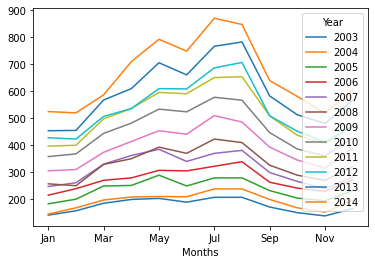

In [20]:
monthly_sales.plot()

**Making yearly data and plotting it to check year patterns using BOX PLOT

In [21]:
yearly_sales = pd.pivot_table(df, values='Tractor-Sales', columns='Months', index='Year')
yearly_sales

Months,Apr,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep
Year,,,,,,,,,,,,
2003,199,207,165,157,141,207,189,185,203,138,150,171
2004,208,238,196,168,145,238,209,197,210,152,168,199
2005,251,279,232,200,183,279,249,249,289,194,204,232
2006,279,339,272,239,215,322,305,270,307,229,241,263
2007,362,381,281,261,247,370,340,330,385,239,266,299
2008,350,410,321,250,257,423,370,329,393,270,289,326
2009,414,486,389,310,305,510,441,374,454,315,345,393
2010,482,567,428,368,358,578,524,444,534,360,386,447
2011,536,654,470,400,397,651,591,498,596,406,437,509


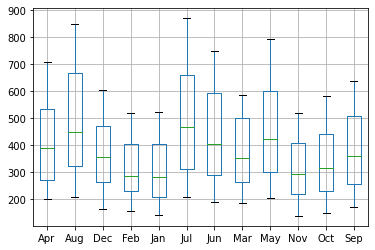

In [22]:
yearly_sales.boxplot()

***Inferences:***
+ The tractor sales have been increasing without fall every year.
+ July and August are the peark months for tractor sales and the variance and the mean value in July and August are also much higher than any of the other months.
+ We can see a seasonal cycle of 12 months where the mean value of each month starts with a increasing trend in the beginning of the year and drops down towards the end of the year.
+ We can see a seasonal effect with a cylce of 12 months.

**Decomposing the Time Series**

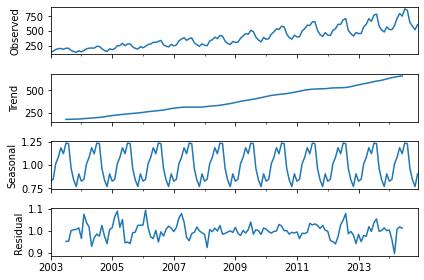

In [23]:
decomp = sm.tsa.seasonal_decompose(df_ts, model='multiplicative')
fig = decomp.plot()

**P,D,Q paramters**

In [24]:
d=q=range(0,2) #d=no. of non-seasonal difference needed for stationarity, q=no. of larg/forecast error
p = range(0,4) #no. of autoregressive term

In [25]:
pdq = list(itertools.product(p,d,q))
pdq

[(0, 0, 0),
 (0, 0, 1),
 (0, 1, 0),
 (0, 1, 1),
 (1, 0, 0),
 (1, 0, 1),
 (1, 1, 0),
 (1, 1, 1),
 (2, 0, 0),
 (2, 0, 1),
 (2, 1, 0),
 (2, 1, 1),
 (3, 0, 0),
 (3, 0, 1),
 (3, 1, 0),
 (3, 1, 1)]

In [26]:
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in pdq]
seasonal_pdq

[(0, 0, 0, 12),
 (0, 0, 1, 12),
 (0, 1, 0, 12),
 (0, 1, 1, 12),
 (1, 0, 0, 12),
 (1, 0, 1, 12),
 (1, 1, 0, 12),
 (1, 1, 1, 12),
 (2, 0, 0, 12),
 (2, 0, 1, 12),
 (2, 1, 0, 12),
 (2, 1, 1, 12),
 (3, 0, 0, 12),
 (3, 0, 1, 12),
 (3, 1, 0, 12),
 (3, 1, 1, 12)]

In [27]:
print('ARIMAX: {} X {}'.format(pdq[1], seasonal_pdq[1]))

ARIMAX: (0, 0, 1) X (0, 0, 1, 12)


# Building a SARIMAX model and finding the minimum value for AIC(Akaike Information Criterion)

AIC estimated the quality of each modelm relative to each of the other models. Thus, AIC provides a means of model selection.

ORDER=> The (p,d,q) order of the model for the number of AR parameters, differences, and MA parameters. d must be an integer indicating the integration order of the process, while p and q may either be an integers indicatiung the AR and MA orders.

Seasanal_Order -> The (P,D,Q,s) order of the seasonal component of the modelf or the AR paramters, differences, MA parameters, and the periodicity. d must be an integer indicating the integration order of the process, while p and q may either be an integers indicating the AR and MA order.

In [28]:
warnings.filterwarnings('ignore')
AIC = []
SARIMAX_model = []

for param in pdq:
  for param_seasonal in seasonal_pdq:
    try:
      mod = sm.tsa.statespace.SARIMAX(df_ts, order=param, seasonal_order = param_seasonal)
      results = mod.fit()
      print('SARIMAX{}x{} = AIC:{}'.format(param, param_seasonal, results.aic),end='\r')
      AIC.append(results.aic)
      SARIMAX_model.append([param, param_seasonal])
    except:
      continue

In [29]:
# #Smallest AIC
print('The smallest AIC {} for model SARIMAX {} x {}'.format(min(AIC), SARIMAX_model[AIC.index(min(AIC))][0], SARIMAX_model[AIC.index(min(AIC))][1]))

The smallest AIC 1111.4860860090173 for model SARIMAX (2, 1, 1) x (2, 1, 1, 12)


In [30]:
SARIMAX_model[AIC.index(min(AIC))][0]

(2, 1, 1)

In [31]:
min(AIC)

1111.4860860090173

In [32]:
AIC.index(min(AIC))

181

In [33]:
SARIMAX_model[239]

[(3, 1, 1), (2, 1, 0, 12)]

In [34]:
mod = sm.tsa.statespace.SARIMAX(df_ts, order=SARIMAX_model[AIC.index(min(AIC))][0], seasonal_order=SARIMAX_model[AIC.index(min(AIC))][1],enforce_stationarity=False, enforce_invertibility=False)

In [35]:
results = mod.fit()

**Diganostic plot**

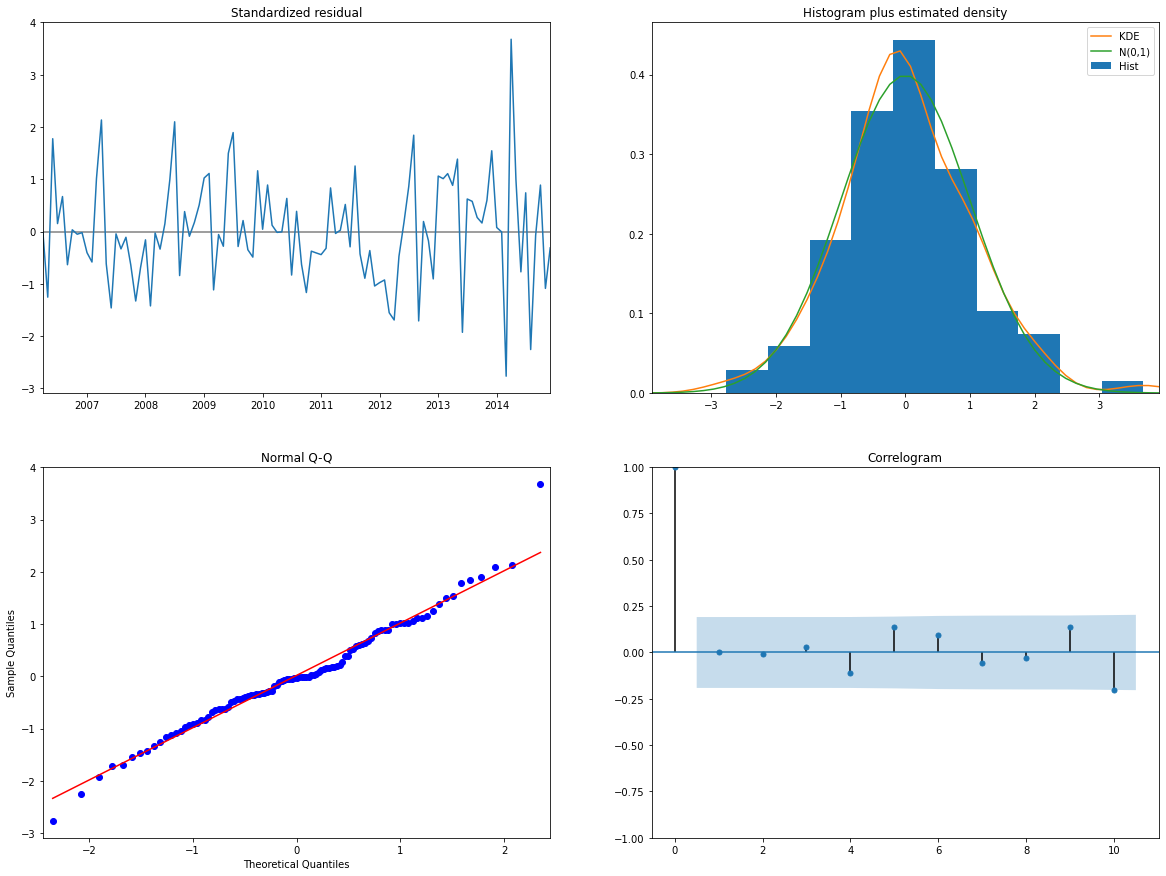

In [36]:
results.plot_diagnostics(figsize=(20,15))
plt.show()

**Predictions**

In [37]:
#in this case the model is used to predict data that the model was built on.
#1-step ahead forecasting implies that each forecasted point is used to predict the following one.
pred0 = results.get_prediction(start='2003-01-01', dynamic=False)
pred0_ci = pred0.conf_int()

In [38]:
#In sample prediction with dynamic forecasting of the last year
#Again, the model is used to predict data that the model was built on
pred1 = results.get_prediction(start='2003-01-01', dynamic=True)
pred1_ci = pred1.conf_int() 

In [39]:
#'True' forecasting of out of sample data
#in this case the model is asked to predict data it has not seen before.
pred2 = results.get_forecast('2016-01-01')
pred2_ci = pred2.conf_int()

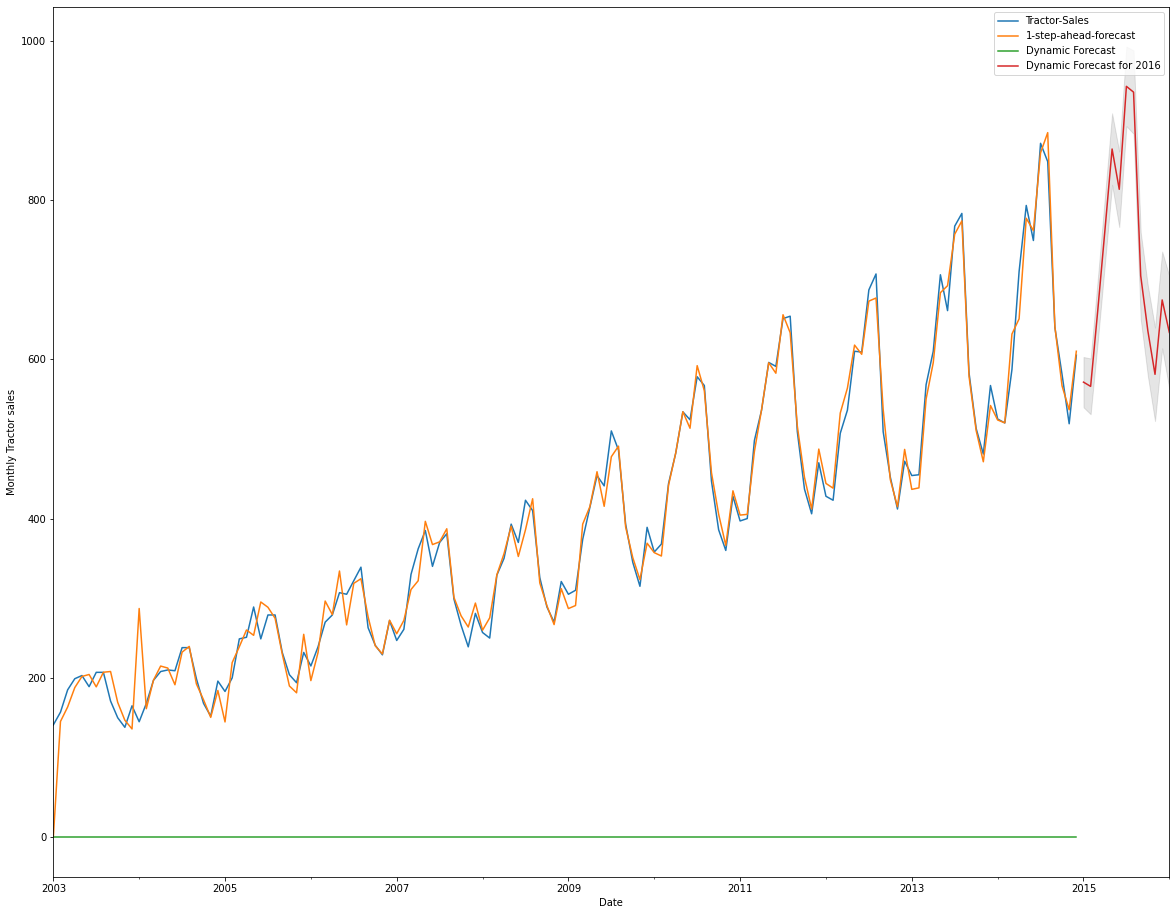

In [47]:
#plot the predicted values
ax = df_ts.plot(figsize=(20,16))
pred0.predicted_mean.plot(ax=ax, label='1-step-ahead-forecast')
pred1.predicted_mean.plot(ax=ax, label='Dynamic Forecast')
pred2.predicted_mean.plot(ax=ax, label='Dynamic Forecast for 2016')
ax.fill_between(pred2_ci.index, pred2_ci.iloc[:,0], pred2_ci.iloc[:,1], color='k', alpha=0.1)

plt.ylabel('Monthly Tractor sales')
plt.xlabel('Date')
plt.legend()
plt.show()

In [48]:
pred1

In [42]:
pred2_ci.head()

,lower Tractor-Sales,upper Tractor-Sales
2015-01-01,539.679835,602.816354
2015-02-01,530.905379,600.920450
2015-03-01,622.574252,700.663881
2015-04-01,719.945936,804.028706
2015-05-01,818.969294,908.711216


In [43]:
pred2_ci.iloc[:,0].head()

2015-01-01    539.679835
2015-02-01    530.905379
2015-03-01    622.574252
2015-04-01    719.945936
2015-05-01    818.969294
Freq: MS, Name: lower Tractor-Sales, dtype: float64

In [44]:
pred2_ci.iloc[:,1].head()

2015-01-01    602.816354
2015-02-01    600.920450
2015-03-01    700.663881
2015-04-01    804.028706
2015-05-01    908.711216
Freq: MS, Name: upper Tractor-Sales, dtype: float64

In [45]:
pred2_ci.index

DatetimeIndex(['2015-01-01', '2015-02-01', '2015-03-01', '2015-04-01',
               '2015-05-01', '2015-06-01', '2015-07-01', '2015-08-01',
               '2015-09-01', '2015-10-01', '2015-11-01', '2015-12-01',
               '2016-01-01'],
              dtype='datetime64[ns]', freq='MS')